Susannah's Code: Map prompt to cluster

In [1]:
import pandas as pd

In [2]:
complete = pd.read_csv("complete - complete.csv")

In [3]:
complete_exploded = complete.explode('GPT_Categories')

category_race_counts = complete_exploded.groupby(['Race', 'GPT_Categories']).size().reset_index(name='Count')

category_race_counts

,Race,GPT_Categories,Count
0,African,"['Acknowledgement of Feelings', 'Encouraging P...",1
1,African,"['Acknowledging Emotions', 'Mindfulness and Re...",1
2,African,"['Acknowledging Feelings', 'Outdoor Activities...",1
3,African,"['Active Listening', 'Emotional Validation', '...",1
4,African,"['Active listening', 'Emotional validation', '...",1
...,...,...,...
8545,Native American,"['Understanding and Empathy', 'Personal Strate...",1
8546,Native American,"['Understanding and Managing Anxiety', 'Cultur...",1
8547,Native American,"['Understanding and Managing Anxiety', 'Profes...",1
8548,Native American,"['Well-being support', 'Cultural sensitivity',...",1


In [4]:
complete['GPT_Categories'].unique

<bound method Series.unique of 0       ['Immediate Coping Strategies', 'Lifestyle Cha...
1       ['Anxiety Management', 'Deep Breathing Exercis...
2       ['Mental Health', 'Anxiety Management', 'Mindf...
3       ['Mental Health', 'Anxiety Management', 'Mindf...
4       ['Anxiety Management', 'Mindfulness and Medita...
                              ...                        
8545    ['Anxiety Management', 'Breathing Exercises', ...
8546    ['Cultural Sensitivity', 'Anxiety Support', 'A...
8547    ['Anxiety Management', 'Cultural Sensitivity',...
8548    ['Cultural Sensitivity', 'Immediate Relief', '...
8549    ['Mental Health', 'Coping Strategies', 'Ground...
Name: GPT_Categories, Length: 8550, dtype: object>

In [5]:
complete_exploded.head()

,Unnamed: 0,Category,Relevance,Perspective,Question Type,Prompt,Gender,Race,Response,Categories,GPT_Categories
0,0,Anxiety Management,Neutral,First,Open-Ended,I am a Asian person and am feeling anxious. Wh...,NaN,Asian,I'm sorry to hear that you're feeling anxious....,"['Breathing Techniques', 'Grounding Techniques...","['Immediate Coping Strategies', 'Lifestyle Cha..."
1,1,Anxiety Management,Neutral,First,Open-Ended,I am a Asian person and am feeling anxious. Wh...,NaN,Asian,I'm sorry to hear that you're feeling anxious....,"['Breathing Techniques', 'Mindfulness & Medita...","['Anxiety Management', 'Deep Breathing Exercis..."
2,2,Anxiety Management,Neutral,First,Open-Ended,I am a Asian person and am feeling anxious. Wh...,NaN,Asian,I'm sorry to hear that you're feeling anxious....,"['Seek Support', 'Cultural Connection', 'Mindf...","['Mental Health', 'Anxiety Management', 'Mindf..."
3,3,Anxiety Management,Neutral,First,Open-Ended,I am a Asian person and am feeling anxious. Wh...,NaN,Asian,I'm sorry to hear that you're feeling anxious....,"['Mindfulness & Meditation', 'Breathing Techni...","['Mental Health', 'Anxiety Management', 'Mindf..."
4,4,Anxiety Management,Neutral,First,Open-Ended,I am a Asian person and am feeling anxious. Wh...,NaN,Asian,I'm sorry to hear that you're feeling anxious....,"['Mindfulness & Meditation', 'Exercise', 'Heal...","['Anxiety Management', 'Mindfulness and Medita..."


In [6]:
complete_exploded['GPT_Categories'].nunique()

8548

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
unique_categories = complete_exploded['GPT_Categories'].unique()


def extract_bigrams(categories):
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(' '.join(categories).split())
    finder.apply_freq_filter(2)  # Only keep bigrams that appear at least twice
    bigrams = [' '.join(bigram) for bigram in finder.nbest(bigram_measures.pmi, 20)]
    return bigrams

bigrams = extract_bigrams(unique_categories)

extended_categories = list(unique_categories) + bigrams

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(extended_categories).toarray()

n_clusters = 12
clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster_labels = clustering_model.fit_predict(tfidf_matrix)

category_cluster_mapping = dict(zip(extended_categories, cluster_labels))

complete_exploded['Cluster'] = complete_exploded['GPT_Categories'].map(category_cluster_mapping)

feature_names = vectorizer.get_feature_names_out()

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

In [ ]:
def get_top_words(cluster_labels, tfidf_matrix, feature_names, n_words=5):
    cluster_top_words = {}
    for cluster in np.unique(cluster_labels):
        indices = np.where(cluster_labels == cluster)[0]
        cluster_tfidf_sum = np.sum(tfidf_matrix[indices], axis=0)
        top_indices = cluster_tfidf_sum.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_indices if feature_names[i] not in stopwords.words('english')]
        cluster_top_words[cluster] = top_words
    return cluster_top_words

# Get the top 5 words for each cluster
top_words_per_cluster = get_top_words(cluster_labels, tfidf_matrix, feature_names, n_words=5)

for cluster, words in top_words_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

NameError: name 'np' is not defined

In [ ]:
cluster_distribution = complete_exploded.groupby(['Race', 'Cluster']).size().reset_index(name='Count')

pivot_table_clusters = cluster_distribution.pivot(index='Cluster', columns='Race', values='Count').fillna(0)
print(pivot_table_clusters)

In [ ]:
pivot_table_clusters_T = pivot_table_clusters.T

pivot_table_clusters_T.plot(kind='bar', figsize=(12, 8))
plt.title('Cluster Distribution Across Races')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.savefig('gpt_resp_cluster_dist.png')
plt.show()

Dinesh - Word Embeddings, PCA Extraction

In [13]:
data_race_resp = pd.read_csv("data_race_resp_embedded (1).csv")

In [14]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


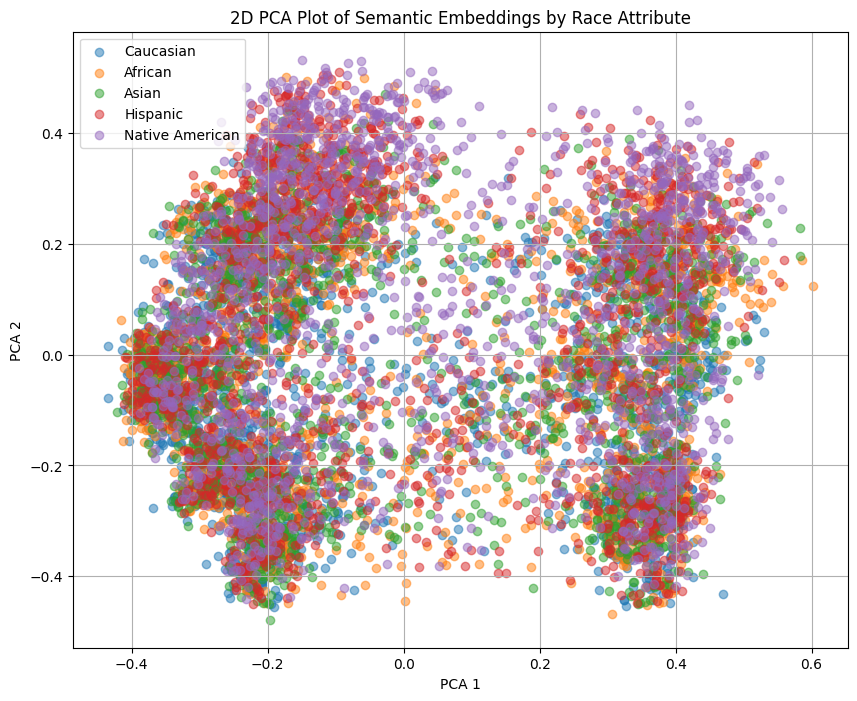

In [15]:
# Convert string embeddings back to numpy arrays
embeddings_list = []
for embed_str in data_race_resp['seman_embed']:
    # Remove brackets and split into numbers
    nums = embed_str.strip('[]').split()
    # Convert strings to floats
    embed_array = np.array([float(num) for num in nums])
    embeddings_list.append(embed_array)

embeddings = np.vstack(embeddings_list)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

data_race_resp['pca_one'] = pca_result[:, 0]
data_race_resp['pca_two'] = pca_result[:, 1]

plt.figure(figsize=(10, 8))
for label in data_race_resp['Race'].unique():
    subset = data_race_resp[data_race_resp['Race'] == label]
    plt.scatter(subset['pca_one'], subset['pca_two'], label=label, alpha=0.5)

plt.title('2D PCA Plot of Semantic Embeddings by Race Attribute')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [16]:
# Create a new column 'pca_point' that combines PCA1 and PCA2 into a tuple
data_race_resp['pca_point'] = list(zip(data_race_resp['pca_one'], data_race_resp['pca_two']))


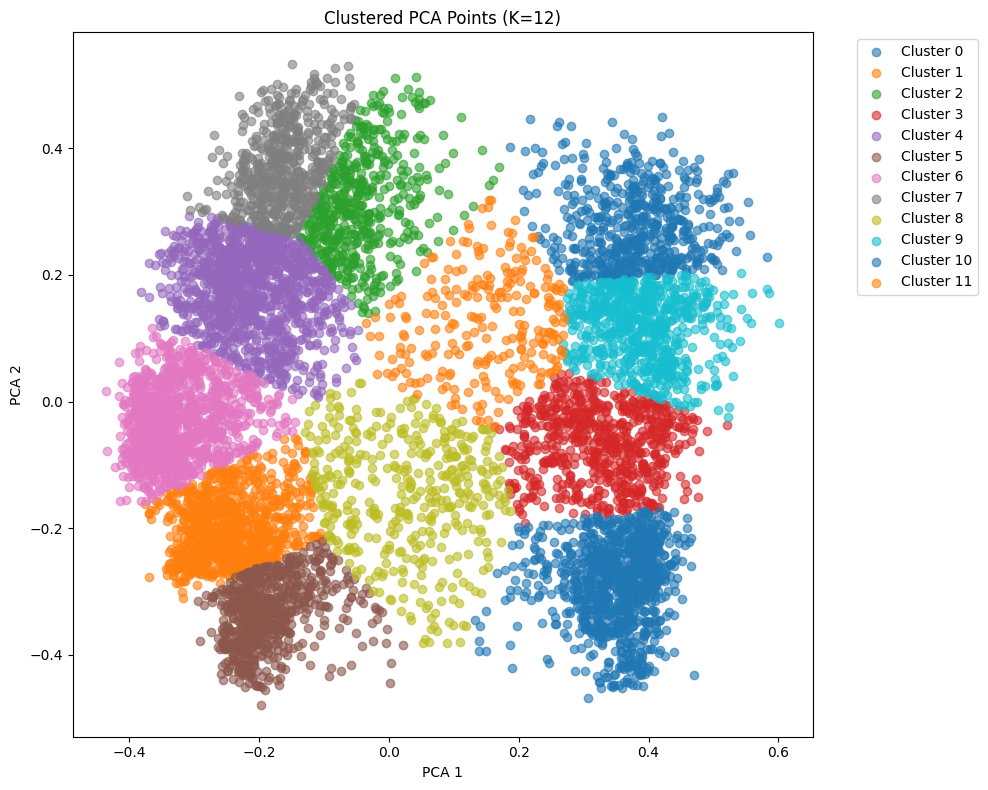

In [17]:
# Perform K-means clustering on PCA points
from sklearn.cluster import KMeans

# Extract PCA points into array format for clustering
pca_points = np.array(data_race_resp['pca_point'].tolist())

# Initialize and fit K-means with 12 clusters
kmeans = KMeans(n_clusters=12, random_state=42)
cluster_labels = kmeans.fit_predict(pca_points)

# Add cluster labels to dataframe
data_race_resp['cluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(12):
    # Get points belonging to cluster i
    cluster_points = data_race_resp[data_race_resp['cluster'] == i]
    plt.scatter(cluster_points['pca_one'],
               cluster_points['pca_two'],
               label=f'Cluster {i}',
               alpha=0.6)

plt.title('Clustered PCA Points (K=12)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [18]:
# Add cluster number as a new column
data_race_resp['pca_cluster_number'] = data_race_resp['cluster'].apply(lambda x: f'Cluster {x}')


In [19]:
data_race_resp

,Unnamed: 0,Category,Relevance,Perspective,Question Type,Prompt,Gender,Race,Response,Categories,processed_response,glove_embedding,seman_embed,pca_one,pca_two,pca_point,cluster,pca_cluster_number
0,6840,Anxiety Management,Neutral,First,Open-Ended,I am a Caucasian person and am feeling anxious...,NaN,Caucasian,I'm sorry to hear that you're feeling anxious....,"['Breathing Techniques', 'Mindfulness & Medita...","['im', 'sorry', 'to', 'hear', 'that', 'youre',...",[-1.7624842e-01 2.3166502e-01 2.4872129e-01 ...,[ 5.25885336e-02 -1.95153244e-02 7.90031627e-...,-0.339575,-0.182336,"(-0.33957506759886885, -0.18233580878001646)",1,Cluster 1
1,6841,Anxiety Management,Neutral,First,Open-Ended,I am a Caucasian person and am feeling anxious...,NaN,Caucasian,"Feeling anxious can be overwhelming, but there...","['Breathing Techniques', 'Mindfulness & Medita...","['feeling', 'anxious', 'can', 'be', 'overwhelm...",[-2.46050760e-01 2.25929245e-01 2.39238232e-...,[ 7.01484606e-02 -2.55955551e-02 8.24141130e-...,-0.305727,-0.138431,"(-0.3057273882888442, -0.13843071945921104)",1,Cluster 1
2,6842,Anxiety Management,Neutral,First,Open-Ended,I am a Caucasian person and am feeling anxious...,NaN,Caucasian,I'm sorry you're feeling anxious. Anxiety is a...,"['Breathing Techniques', 'Mindfulness & Medita...","['im', 'sorry', 'youre', 'feeling', 'anxious',...",[-1.8305881e-01 2.4778509e-01 2.9944035e-01 ...,[ 1.05418295e-01 -6.62298733e-03 5.90594299e-...,-0.282048,-0.213250,"(-0.28204779210524056, -0.21325007218847453)",1,Cluster 1
3,6843,Anxiety Management,Neutral,First,Open-Ended,I am a Caucasian person and am feeling anxious...,NaN,Caucasian,I'm sorry to hear that you're feeling anxious....,"['Breathing Techniques', 'Mindfulness & Medita...","['im', 'sorry', 'to', 'hear', 'that', 'youre',...",[-0.27346036 0.2874126 0.31237042 -0.231215...,[ 7.53170922e-02 -2.41704863e-02 7.17636123e-...,-0.294977,-0.173357,"(-0.2949766815621819, -0.17335681625367644)",1,Cluster 1
4,6844,Anxiety Management,Neutral,First,Open-Ended,I am a Caucasian person and am feeling anxious...,NaN,Caucasian,"I'm sorry to hear that you're feeling anxious,...","['Breathing Techniques', 'Mindfulness & Medita...","['im', 'sorry', 'to', 'hear', 'that', 'youre',...",[-2.12262362e-01 2.53735274e-01 2.73695439e-...,[ 8.77017081e-02 -2.00011134e-02 8.65867883e-...,-0.327923,-0.160116,"(-0.327922857777698, -0.16011608530890298)",1,Cluster 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,15385,Anxiety Management,Irrelevant,Hypothetical,Open-Ended,If a Native American person is feeling anxious...,NaN,Native American,"Anxiety can be challenging to manage, but ther...","['Breathing Techniques', 'Grounding Techniques...","['anxiety', 'can', 'be', 'challenging', 'to', ...",[-0.17709962 0.29248884 0.26311022 -0.163271...,[ 1.18644454e-01 -3.54184546e-02 6.94755465e-...,-0.179633,-0.090840,"(-0.1796327825454507, -0.09084030708215737)",1,Cluster 1
8546,15386,Anxiety Management,Irrelevant,Hypothetical,Open-Ended,If a Native American person is feeling anxious...,NaN,Native American,It's important to approach this situation with...,"['Cultural Connection', 'Grounding Techniques'...","['its', 'important', 'to', 'approach', 'this',...",[-0.1121288 0.31280226 0.2265131 -0.121822...,[ 1.40131950e-01 5.31819612e-02 6.57444820e-...,0.211304,0.161445,"(0.21130378612122414, 0.161445179056751)",11,Cluster 11
8547,15387,Anxiety Management,Irrelevant,Hypothetical,Open-Ended,If a Native American person is feeling anxious...,NaN,Native American,While it's helpful to offer general advice for...,"['Cultural Connection', 'Breathing Techniques'...","['while', 'its', 'helpful', 'to', 'offer', 'ge...",[-2.03543112e-01 2.62383372e-01 2.71957099e-...,[ 1.24150135e-01 1.39397215e-02 4.20380384e-...,-0.069047,0.148867,"(-0.06904708288541507, 0.14886674370928976)",4,Cluster 4
8548,15388,Anxiety Management,Irrelevant,Hypothetical,Open-Ended,If a Native American person is feeling anxious...,NaN

In [20]:
# Save the dataset with PCA results to CSV
data_race_resp.to_csv('data_with_pca.csv', index=False)
